# Training a cNN to detect roadsigns
In order to process roadsigns in the autonomous car of the Freie Universität, we want to train a convolutional (deep) neural network.

This network is supposed to distinguish between different classes of signs (stop, attention, train crossing etc) and the final model will then be integrated to the autonomos ROS structure.

This notebook shall download the dataset, read it in and then train the classifier. Afterwards, a validation of the training procedure will be done.

In [205]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import urllib2, cStringIO, zipfile
import csv
import os
import random
from sklearn import preprocessing
import warnings
import scipy.misc as misc
from scipy.ndimage import zoom
import math

## Set global parameters such as image size or channels

**Options include:**
* Size of the images
* Which color channels are used (RGB or YUV)
* How many new images are artificially added?
* How do we normalize the image?

In [2]:
img_size = (32, 32)

## Download the training dataset

In [3]:
url = 'http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip'

if not os.path.exists('GTSRB/Final_Training/Images'):
    try:
        remotezip = urllib2.urlopen(url)
        zipinmemory = cStringIO.StringIO(remotezip.read())
        zip = zipfile.ZipFile(zipinmemory)
        zip.extractall('.')
    except urllib2.HTTPError:
        pass

## Download the test dataset

In [4]:
#url = 'http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_Images.zip'

#if not os.path.exists('GTSRB/Final_Test/Images'):
#    try:
#        remotezip = urllib2.urlopen(url)
#        zipinmemory = cStringIO.StringIO(remotezip.read())
#        zip = zipfile.ZipFile(zipinmemory)
#        zip.extractall('.')
#    except urllib2.HTTPError:
#        pass

## Read the data in and scale it to a fixed resolution

In [369]:
def scale_image(img, scale_factor):
    scaled = misc.imresize(img, scale_factor)
    new_img = np.zeros_like(img)
    left_x = scaled.shape[0]/2.-img.shape[0]/2.
    right_x = scaled.shape[0]/2.+img.shape[0]/2.
    left_y = scaled.shape[1]/2.-img.shape[1]/2.
    right_y = scaled.shape[1]/2.+img.shape[1]/2.

    if rand_scale > 1: # scaled is larger than original img
        new_img = scaled[math.ceil(left_x):math.ceil(right_x), math.ceil(left_y):math.ceil(right_y)]
    else: # scaled is smaller than original img
        new_img[math.floor(-left_x):math.floor(right_x), math.floor(-left_y):math.floor(right_y)] = scaled
    return new_img

def scale_image_gs(img, scale_factor):
    scaled = misc.imresize(img, scale_factor)
    new_img = np.zeros_like(img)
    left_x = scaled.shape[0]/2.-img.shape[0]/2.
    right_x = scaled.shape[0]/2.+img.shape[0]/2.
    left_y = scaled.shape[1]/2.-img.shape[1]/2.
    right_y = scaled.shape[1]/2.+img.shape[1]/2.

    if rand_scale > 1: # scaled is larger than original img
        new_img = scaled[math.ceil(left_x):math.ceil(right_x), math.ceil(left_y):math.ceil(right_y)]
    else: # scaled is smaller than original img
        new_img[math.floor(-left_x):math.floor(right_x), math.floor(-left_y):math.floor(right_y)] = scaled
    new_img = new_img.reshape(img_size[0], img_size[1], 1)
    return new_img

def getSingleImage(path, all_channels, normalize):
    # read image
    img = Image.open(path) # the 1th column is the filename
    img_resized = img.resize((img_size[0], img_size[1]), Image.LINEAR)
    del img
    np_img = np.array(img_resized.convert('YCbCr'))
    del img_resized
    Y_channel = np_img[:,:,0]
    
    if normalize:
        scaler = preprocessing.MinMaxScaler(feature_range=(0, 255), copy=False).fit(Y_channel)
        scaler.transform(Y_channel)

    if not all_channels:
        return Y_channel.reshape(img_size[0], img_size[1], 1)
    else:
        np_img[:,:,0] = Y_channel
        return np_img

def read_training_set(rootpath, train_test_split, all_channels=True, normalize=True):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''

    training_images = [] # images
    training_labels = [] # corresponding labels
    
    test_images = [] # images
    test_labels = [] # corresponding labels

    # loop over all 43 classes
    with warnings.catch_warnings(): #ignore warnings from sklearn
        warnings.simplefilter("ignore")
        for c in range(0,43):
            prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
            gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
            gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
            gtReader.next() # skip header

            # loop over all images in current annotations file
            for row in gtReader:
                np_img = getSingleImage(prefix + row[0], all_channels, normalize) # the 1th column is the filename

                if random.random() <= train_test_split:
                    test_images.append(np_img)
                    test_labels.append(row[7])
                else:
                    training_images.append(np_img)
                    training_labels.append(row[7])
            gtFile.close()
            print "Loaded images from class " + str(c)
        return (training_images, training_labels, test_images, test_labels)

def read_test_set(rootpath):

    images = [] # images
    gtFile = open(rootpath + '/GT-final_test.test.csv') # annotations file
    gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
    gtReader.next() # skip header

    # loop over all images in current annotations file
    for row in gtReader:
        print "Filename: " + rootpath + '/' + row[0]
        np_img = getSingleImage(rootpath + '/' + row[0]) # the 1th column is the filename
        images.append(np_img)
    gtFile.close()

    return (images, labels)

In [382]:
trainImg, trainLabels, testImg, testLabels = read_training_set('GTSRB/Final_Training/Images', 0.1, all_channels=False, normalize=True)

Loaded images from class 0
Loaded images from class 1
Loaded images from class 2
Loaded images from class 3
Loaded images from class 4
Loaded images from class 5
Loaded images from class 6
Loaded images from class 7
Loaded images from class 8
Loaded images from class 9
Loaded images from class 10
Loaded images from class 11
Loaded images from class 12
Loaded images from class 13
Loaded images from class 14
Loaded images from class 15
Loaded images from class 16
Loaded images from class 17
Loaded images from class 18
Loaded images from class 19
Loaded images from class 20
Loaded images from class 21
Loaded images from class 22
Loaded images from class 23
Loaded images from class 24
Loaded images from class 25
Loaded images from class 26
Loaded images from class 27
Loaded images from class 28
Loaded images from class 29
Loaded images from class 30
Loaded images from class 31
Loaded images from class 32
Loaded images from class 33
Loaded images from class 34
Loaded images from class 35
Lo

(32, 32, 1)
(32, 32, 3)
(32, 32, 1)
(32, 32, 3)


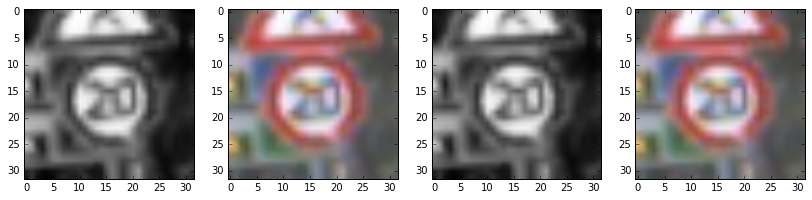

In [383]:
fig = plt.figure(figsize=(14,8))
path = 'GTSRB/Final_Training/Images/00000/00000_00000.ppm'
plt.subplot(1, 4, 1)
img1 = getSingleImage(path, False, False)
print img1.shape
plt.imshow(img1.squeeze(), cmap='Greys_r')
plt.subplot(1, 4, 2)
img2 = getSingleImage(path, True, False)
print img2.shape
x = misc.toimage(img2, high=255, low=0, mode='YCbCr')
plt.imshow(x)
plt.subplot(1, 4, 3)
img3 = getSingleImage(path, False, True)
print img3.shape
plt.imshow(img3.squeeze(), cmap='Greys_r')
plt.subplot(1, 4, 4)
img4 = getSingleImage(path, True, True)
print img4.shape
x = misc.toimage(img4, high=255, low=0, mode='YCbCr')
plt.imshow(x)

-6.45592929182 1.04140350241
(32, 32, 1)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


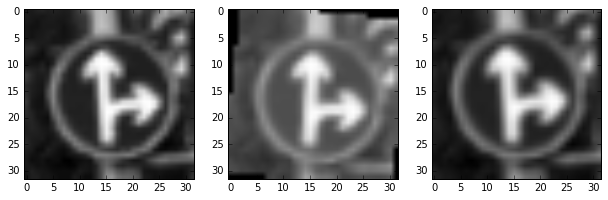

In [384]:
fig = plt.figure(figsize=(14,8))
rand_index = random.randrange(0, len(trainImg)-1)
rand_angle = (random.random()*15.) * (-1)**(random.random() > 0.5)
rand_scale = 1 + random.random()*0.2 * (-1)**(random.random() > 0.5)
print rand_angle, rand_scale
plt.subplot(1, 4, 1)
print trainImg[rand_index].shape
if trainImg[rand_index].shape[2] > 1:
    x = misc.toimage(trainImg[rand_index], mode='YCbCr')
    plt.imshow(x)
else:
    plt.imshow(trainImg[rand_index].squeeze(), cmap='Greys_r')
    plt.subplot(1,4,2)
    
if trainImg[rand_index].shape[2] > 1:
    rotated = misc.imrotate(trainImg[rand_index], rand_angle)
    print rotated.shape
    y = misc.toimage(rotated, mode='YCbCr')
    plt.imshow(y)
else:
    rotated = misc.imrotate(trainImg[rand_index].squeeze(), rand_angle)
    plt.imshow(rotated, cmap='Greys_r')
plt.subplot(1,4,3)
if trainImg[rand_index].shape[2] > 1:
    scaled = scale_image(trainImg[rand_index], rand_scale)
    z = misc.toimage(scaled, mode='YCbCr')
    plt.imshow(z)
else:
    scaled = scale_image_gs(trainImg[rand_index].squeeze(), rand_scale)
    plt.imshow(scaled.squeeze(), cmap='Greys_r')

In [385]:
print "Number of training images: " + str(len(trainImg))
print "Number of training labels: " + str(len(trainLabels))
print "Number of testing images: " + str(len(testImg))
print "Number of testing labels: " + str(len(testLabels))
print "Train Test Ratio: " + str(len(trainImg) / (len(testImg)*100.))

Number of training images: 35318
Number of training labels: 35318
Number of testing images: 3891
Number of testing labels: 3891
Train Test Ratio: 0.0907684399897


## Permute the training data randomly and make it a big matrix

In [386]:
permutation = np.random.permutation(len(trainImg))
train_set = np.array([trainImg[idx] for idx in permutation], dtype=np.float32)
train_labels = [trainLabels[idx] for idx in permutation]
test_set = np.array(testImg, dtype=np.float32)
test_labels = testLabels

## Transform labels to one-hot-vectors and make it a matrix

In [387]:
train_labels_oh = []
number_of_classes = 43
for label in train_labels:
    new_label = np.zeros(number_of_classes)
    new_label[int(label)] = 1
    train_labels_oh.append(new_label)
train_labels = np.array(train_labels_oh, dtype=np.float32)

test_labels_oh = []
for label in test_labels:
    new_label = np.zeros(number_of_classes)
    new_label[int(label)] = 1
    test_labels_oh.append(new_label)
test_labels = np.array(test_labels_oh, dtype=np.float32)

## Show some of the images

(32, 32, 1)
[14230, 27151, 6182, 6414, 34692, 11577, 30373, 9974, 12794, 1396, 13824, 8409, 19611, 29020, 14169, 9861, 31260, 32311, 8808, 12268, 5309, 26345, 34082, 31760, 13386, 34588, 17175, 5533, 9362, 16319, 8638, 22028, 3660, 5037, 6560, 4957, 31543, 20082, 3498, 29111, 5869, 34541, 28675, 15304, 7285, 5941, 9453, 19740, 28342, 11581, 15847, 27792, 6782, 5794, 19461, 22902, 22468, 18996, 8084, 34262]


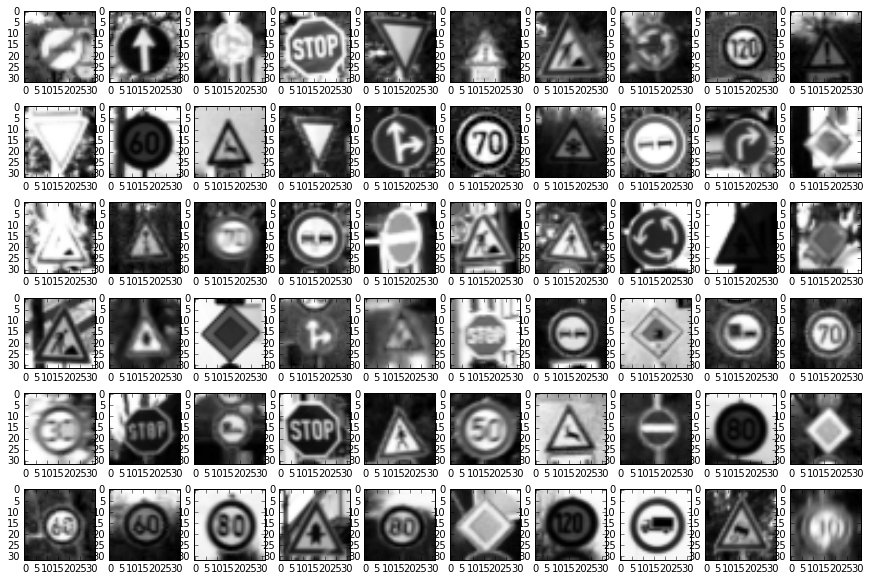

In [388]:
%matplotlib inline
num_of_plotted_imgs = 60
imgs_per_line = 10
random_images = [random.randrange(train_set.shape[0]) for i in xrange(num_of_plotted_imgs)]
print train_set[random_images[0]].shape
print random_images
fig = plt.figure(figsize=(15, 10))
for i in xrange(num_of_plotted_imgs):
    fig.add_subplot(num_of_plotted_imgs / imgs_per_line, imgs_per_line, i+1)

    if train_set[random_images[i]].shape[2] == 1: #only y channel
        plt.imshow(train_set[random_images[i]].squeeze(), cmap='Greys_r')
    else:
        x = misc.toimage(train_set[random_images[i]], mode='YCbCr')
        plt.imshow(x)
plt.show()

## Add images with random rotations and scales
To further improve the quality of the classifier, add some more images.
These new training images are derived from previous data by rotating and translating randomly.

In [392]:
desired_number_of_images = 100000
print train_set.shape[0]
additional_images = []
additional_labels = []
for i in xrange(train_set.shape[0], desired_number_of_images):
    rand_index = random.randrange(0, train_set.shape[0])
    rand_img = train_set[rand_index]
    if random.random() > 0.5: # rotate
        rand_angle = (random.random()*15.) * (-1)**(random.random() > 0.5)
        if rand_img.shape[2] > 1:
            additional_images.append(misc.imrotate(rand_img, rand_angle))
        else:
            additional_images.append(misc.imrotate(rand_img.squeeze(), rand_angle).reshape(img_size[0], img_size[1], 1))
    else:
        rand_scale = 1 + random.random()*0.1 * (-1)**(random.random() > 0.5)
        if rand_img.shape[2] > 1:
            additional_images.append(scale_image(rand_img, rand_scale))
        else:
            additional_images.append(scale_image_gs(rand_img.squeeze(), rand_scale))
    additional_labels.append(train_labels[rand_index])

additional_images = np.asarray(additional_images, dtype=np.float32)
additional_labels = np.asarray(additional_labels, dtype=np.float32)
print additional_images.shape
print additional_labels.shape

50000


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(50000, 32, 32, 1)
(50000, 43)


(32, 32, 1)
[25438, 27804, 45999, 22880, 24929, 29298, 33523, 14082, 5596, 37789, 9869, 20328, 24484, 23693, 46595, 27142, 7347, 24525, 2295, 8998, 34948, 8258, 34235, 24954, 24964, 23345, 32408, 32647, 16487, 28576, 47522, 6605, 49428, 23231, 8575, 4724, 41035, 6357, 45521, 1140, 18260, 28835, 31556, 24984, 16456, 40484, 23953, 34078, 25015, 45809, 24578, 32369, 26787, 49074, 14123, 42594, 14890, 21682, 19238, 39150]


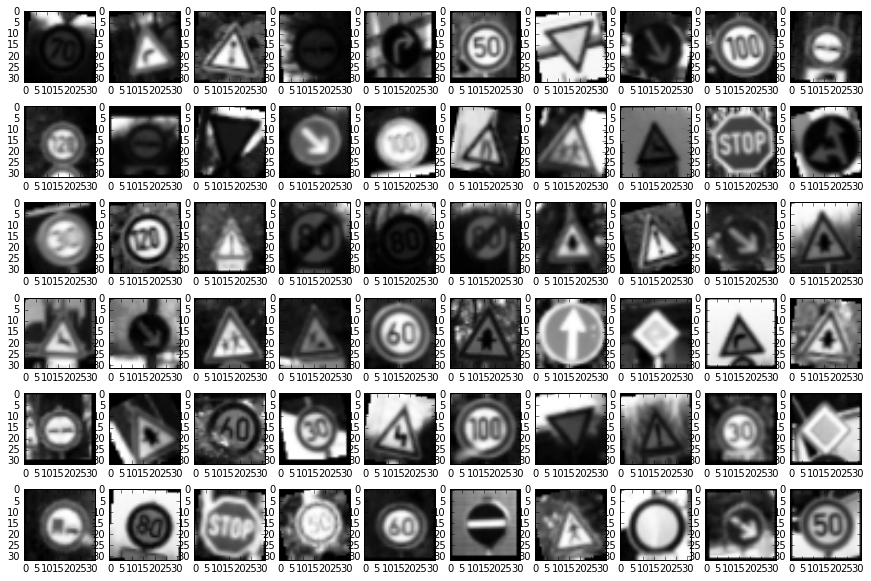

In [393]:
num_of_plotted_imgs = 60
imgs_per_line = 10
random_images = [random.randrange(additional_images.shape[0]) for i in xrange(num_of_plotted_imgs)]
print additional_images[random_images[0]].shape
print random_images
fig = plt.figure(figsize=(15, 10))
for i in xrange(num_of_plotted_imgs):
    fig.add_subplot(num_of_plotted_imgs / imgs_per_line, imgs_per_line, i+1)

    if additional_images[random_images[i]].shape[2] == 1: #only y channel
        plt.imshow(additional_images[random_images[i]].squeeze(), cmap='Greys_r')
    else:
        x = misc.toimage(additional_images[random_images[i]], mode='YCbCr')
        plt.imshow(x)
plt.show()

In [394]:
train_set = np.concatenate((train_set, additional_images), axis=0)
train_labels = np.concatenate((train_labels, additional_labels), axis=0)
print train_set.shape
print train_labels.shape

(100000, 32, 32, 1)
(100000, 43)


## Pickle the images to a file that can easily be loaded

In [395]:
import pickle
train_name = 'train_data_gray_norm_aug.pkl'
with open(train_name, 'w') as f:
    pickle.dump([train_set, train_labels], f, pickle.HIGHEST_PROTOCOL)

test_name = 'test_data_gray_norm_aug.pkl'
with open(test_name, 'w') as f:
    pickle.dump([test_set, test_labels], f, pickle.HIGHEST_PROTOCOL)


In [201]:
angles = []
for i in range(1000):
    angles.append((random.random()*15.) * (-1)**(random.random() > 0.5))
print np.sum(np.array(angles) > 0)
print np.sum(np.array(angles) < 0)

491
509
